## Постановка

Написать алгоритм классификации, принимающий на вход изображение, обработанное фильтром, и определяющий этот фильтр.

Входные данные:
 - массив исходных изображений до обработки. Их размер различен
 - массив обработанных изображений путем применения фильтра
 
Выходные данные:
 - название фильтра, примененное к конкретному изображению

## Подготовка

In [24]:
import cv2
import os
import numpy as np
from PIL import Image
import matplotlib.pylab as plt
import pandas as pd
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from skimage import data, io, filters
import seaborn as sns
import cv2
from skimage.color import rgb2grey
from skimage import data, io, filters
%matplotlib inline

## Собираем названия фотографий (не забудь выровнить число картинок по папкам!)

In [5]:
directory = '../Task1'
files = os.listdir(directory)
names = os.listdir(directory + '/Kelvin') # предполагаем, что во всех папках одинаковый список фотографий

## Собираем статистику по фотографиям

### 1. Гистограммы по каждому каналу фотографии

Потребовалось 8 минут, 50МБ данных

In [6]:
%%time
for j in range(len(names)):
    for i in range(len(files)):
        image = cv2.imread(directory + '/' + files[i] + '/' + names[j], 1)
        hst1 = np.histogram(np.array(image[:,:,0]).ravel(), bins=100, normed=True)[0]
        hst2 = np.histogram(np.array(image[:,:,1]).ravel(), bins=100, normed=True)[0]
        hst3 = np.histogram(np.array(image[:,:,2]).ravel(), bins=100, normed=True)[0]
        
        s = ' '
        hst = np.concatenate([hst1,hst2, hst3])
        for h in hst:
            s = s + str(h) + ' '
        open("data_hst.txt", 'a').write(s + names[j].partition('.')[0] + ' ' + files[i] + '\n')
    open("data_hst.txt", 'a').write('\n')
    

CPU times: user 6min 13s, sys: 4.37 s, total: 6min 18s
Wall time: 8min


### 2. Гистограмма по преобразованной фотографии (применяем фильтр Собель)

Фильтр собель - неплохая попытка, которая прибавила несколько процентов к качеству классификации.

Потребовалось 8.5 минут, 30МБ данных

In [9]:
%%time
for j in range(len(names)):
    for i in range(len(files)):
        image = cv2.imread(directory + '/' + files[i] + '/' + names[j], 0)
        a = filters.sobel(rgb2grey(image))
        hst = np.histogram(np.array(a).ravel(), bins=200, normed=True)[0]
        
        s = ' '
        for h in hst:
            s = s + str(h) + ' '
        open("data_sobel.txt", 'a').write(s + names[j].partition('.')[0] + ' ' + files[i] +  '\n')
    open("data_sobel.txt", 'a').write('\n')

CPU times: user 6min 33s, sys: 12.7 s, total: 6min 46s
Wall time: 8min 31s


## Загрузка датасетов

In [15]:
df_h = pd.read_csv("data_hst.txt", sep=' ', header=None)
df_h = df_h.drop([0, df_h.shape[1] - 1, df_h.shape[1]-2], axis=1)
df_h['target'] = pd.Series(i % 11 for i in range(df_h.shape[0]))

df_s = pd.read_csv("data_sobel.txt", sep=' ', header=None)
df_s = df_s.drop([0, df_s.shape[1]-1, df_s.shape[1]-2], axis=1)
df_s.columns = range(301,501)

df = pd.concat([df_h, df_s], axis =1)

#### Мотивация

Гистограммы одних и тех же фотографий имеют сильно различающиеся пики!

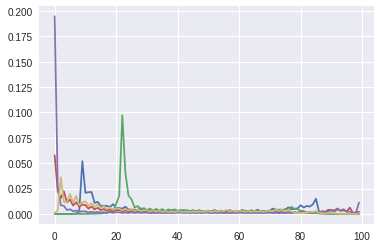

In [32]:
plt.plot(list(df.iloc[0,:100]))
plt.plot(list(df.iloc[1,:100]))
plt.plot(list(df.iloc[2,:100]))
plt.plot(list(df.iloc[3,:100]))
plt.plot(list(df.iloc[4,:100]))
plt.show()

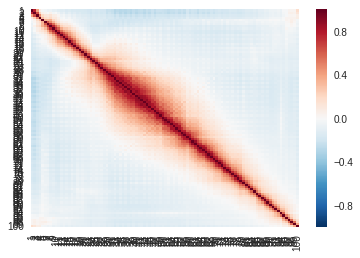

In [29]:
corr_matrix = df_h.iloc[:,:100].corr()
sns.heatmap(corr_matrix);

## Кроссвалидация

In [22]:
test_y = df['target'][:867]
test_X = df.drop(['target'], axis = 1)[:867]
train_y = df['target'][867:]
train_X = df.drop(['target'], axis = 1)[867:]

или

In [ ]:
skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(df.iloc[:,:-1], df['target']):
    X_train, X_test = df.iloc[train_index,:-1], df.iloc[test_index,:-1]
    y_train, y_test = df['target'][train_index], df['target'][test_index]
    %time gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.01).fit(X_train, y_train)
    predictions = gbm.predict(X_test)
    print('acc:', metrics.accuracy_score(y_test, predictions))
    

## Обучение

In [25]:
%time gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.01).fit(train_X, train_y)
predictions = gbm.predict(test_X)
metrics.accuracy_score(test_y, predictions)

CPU times: user 48min 46s, sys: 2.94 s, total: 48min 49s
Wall time: 13min 23s


0.87658592848904271

Здесь получено примерно 0.88 accuracy без оптимизации параметров.

Однако на приватных данных после обучения на всех имеющихся данных было получено accuracy = 0.934. Предполагаю, что можно еще улучшить результат, если увеличить размер bins в гистограмме

## Преобразование к требуемому формату

Чтобы получить предсказания на финальных данных, нужно собрать информацию из гистограмм (аналогично, как сделано выше) и сохранить в df_test

In [ ]:
filters = {0: 'Gingham', 1: 'Toaster', 2: 'Lo-Fi', 3: 'Kelvin', 4: 'Helena', 5: 'Maven', 6: 'Juno', 7: 'Ginza',\
     8: 'Ludwig', 9: 'Moon', 10: 'Slumber'}

predictions = gbm.predictions(df_test)
answers = []
for i in predictions:
    answers.append(filters[i])
    
a = pd.DataFrame(index=range(500), data = names)
b = pd.DataFrame(index=range(500), data = answers)

df_answers = pd.concat([a,b], axis=1)
df_answers.columns = ['img', 'filter']

df_answers.to_csv("answers.csv", index=None)